In [1]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np

logs\toy-goal-2d\cemrl\cemrl-p2e_45\heatmaps/heatmap_train*_2d.npy
32229.0784674956


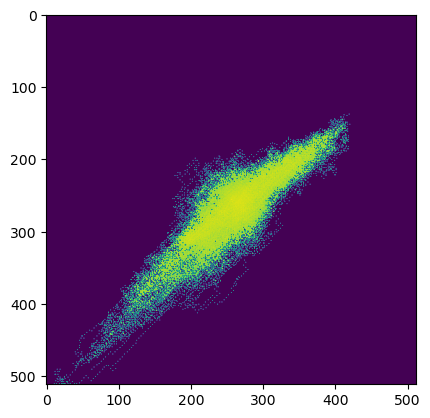

logs\toy-goal-2d\cemrl\cemrl-p2e_45\heatmaps/heatmap_exploration_eval*_2d.npy
1163.8822348665033


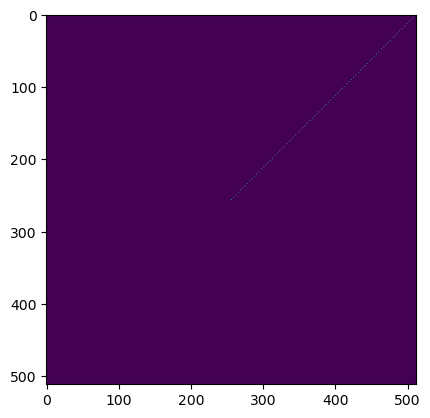

logs\toy-goal-2d\cemrl\cemrl-p2e_45\heatmaps/heatmap_exploration_[0-9]*_2d.npy
33109.32776275868


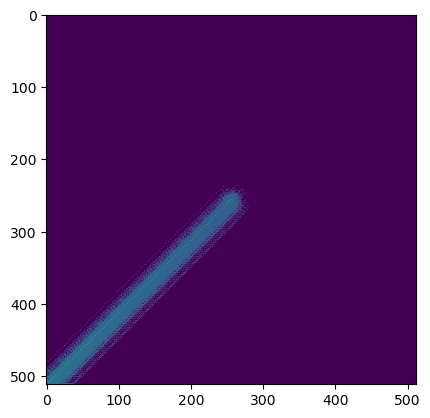

logs\toy-goal-2d\cemrl\cemrl-p2e_45\heatmaps/heatmap_eval*_2d.npy
2327.882222951875


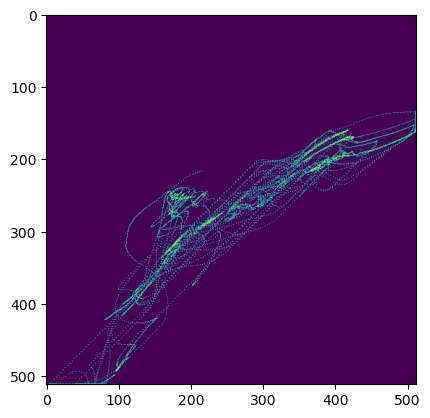

In [3]:
experiment = "logs\\toy-goal-2d\\cemrl\\cemrl-p2e_45\\heatmaps"
# experiment = "logs/toy-goal-2d/p2e-cemrl/default-mpc_25/heatmaps"
# experiment = "logs/cemrl/run_127/heatmaps"
for path in [f"{experiment}/heatmap_train*_2d.npy", f"{experiment}/heatmap_exploration_eval*_2d.npy", f"{experiment}/heatmap_exploration_[0-9]*_2d.npy", f"{experiment}/heatmap_eval*_2d.npy"]:
# for path in [f"{experiment}/eval_*_2d.npy", f"{experiment}/training*_2d.npy", f"{experiment}/exploration*_2d.npy"]:
    files = glob(path)
    files.sort(key=lambda x: int(x.split("_")[-3]))
    combined = None
    for file in files[::]:
        heatmap = np.load(file)
        if combined is None:
            combined = heatmap
        else:
            combined += heatmap
        # print(file)
        # print(heatmap[0].sum())
        # plt.imshow(np.sqrt(heatmap[0]))
        # plt.show()
    print(path)
    print(combined.sum())
    plt.imshow(np.log(combined[0] + 1e-10))
    plt.show()

In [59]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

from torch.nn.parameter import Parameter


class NeuralAccumulatorCell(nn.Module):
    """A Neural Accumulator (NAC) cell [1].

    Attributes:
        in_dim: size of the input sample.
        out_dim: size of the output sample.

    Sources:
        [1]: https://arxiv.org/abs/1808.00508
    """
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.W_hat = Parameter(torch.Tensor(out_dim, in_dim))
        self.M_hat = Parameter(torch.Tensor(out_dim, in_dim))
        self.register_parameter('bias', None)

        init.kaiming_uniform_(self.W_hat, a=math.sqrt(5))
        init.kaiming_uniform_(self.M_hat, a=math.sqrt(5))

    def forward(self, input):        
        W = F.tanh(self.W_hat) * F.sigmoid(self.M_hat)
        return F.linear(input, W, self.bias)

    def extra_repr(self):
        return 'in_dim={}, out_dim={}'.format(
            self.in_dim, self.out_dim
        )


class NAC(nn.Module):
    """A stack of NAC layers.

    Attributes:
        num_layers: the number of NAC layers.
        in_dim: the size of the input sample.
        hidden_dim: the size of the hidden layers.
        out_dim: the size of the output.
    """
    def __init__(self, num_layers, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.num_layers = num_layers
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim

        layers = []
        for i in range(num_layers):
            layers.append(
                NeuralAccumulatorCell(
                    hidden_dim if i > 0 else in_dim,
                    hidden_dim if i < num_layers - 1 else out_dim,
                )
            )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out

import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn.parameter import Parameter


class NeuralArithmeticLogicUnitCell(nn.Module):
    """A Neural Arithmetic Logic Unit (NALU) cell [1].

    Attributes:
        in_dim: size of the input sample.
        out_dim: size of the output sample.

    Sources:
        [1]: https://arxiv.org/abs/1808.00508
    """
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.eps = 1e-10

        self.G = Parameter(torch.Tensor(out_dim, in_dim))
        self.nac = NeuralAccumulatorCell(in_dim, out_dim)
        self.register_parameter('bias', None)

        init.kaiming_uniform_(self.G, a=math.sqrt(5))

    def forward(self, input):
        a = self.nac(input)
        g = F.sigmoid(F.linear(input, self.G, self.bias))
        add_sub = g * a
        log_input = torch.log(torch.abs(input) + self.eps)
        m = torch.exp(self.nac(log_input))
        mul_div = (1 - g) * m
        y = add_sub + mul_div
        return y

    def extra_repr(self):
        return 'in_dim={}, out_dim={}'.format(
            self.in_dim, self.out_dim
        )


class NALU(nn.Module):
    """A stack of NAC layers.

    Attributes:
        num_layers: the number of NAC layers.
        in_dim: the size of the input sample.
        hidden_dim: the size of the hidden layers.
        out_dim: the size of the output.
    """
    def __init__(self, num_layers, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.num_layers = num_layers
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim

        layers = []
        for i in range(num_layers):
            layers.append(
                NeuralArithmeticLogicUnitCell(
                    hidden_dim if i > 0 else in_dim,
                    hidden_dim if i < num_layers - 1 else out_dim,
                )
            )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out
    
class FauxNeuralArithmeticLogicUnitCell(nn.Module):
    """A NALU cell that uses linear layers instead of NACs.

    Attributes:
        in_dim: size of the input sample.
        out_dim: size of the output sample.
    """
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.eps = 1e-10

        self.G = Parameter(torch.Tensor(out_dim, in_dim))
        self.linear = nn.modules.Linear(in_dim, out_dim)
        self.register_parameter('bias', None)

        init.kaiming_uniform_(self.G, a=math.sqrt(5))

    def forward(self, input):
        a = self.linear(input)
        g = F.sigmoid(F.linear(input, self.G, self.bias))
        add_sub = g * a
        log_input = torch.log(torch.abs(input) + self.eps)
        m = torch.exp(self.linear(log_input))
        mul_div = (1 - g) * m
        y = add_sub + mul_div
        return y

    def extra_repr(self):
        return 'in_dim={}, out_dim={}'.format(
            self.in_dim, self.out_dim
        )


class FauxNALU(nn.Module):
    """A stack of NAC layers.

    Attributes:
        num_layers: the number of NAC layers.
        in_dim: the size of the input sample.
        hidden_dim: the size of the hidden layers.
        out_dim: the size of the output.
    """
    def __init__(self, num_layers, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.num_layers = num_layers
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim

        layers = []
        for i in range(num_layers):
            layers.append(
                FauxNeuralArithmeticLogicUnitCell(
                    hidden_dim if i > 0 else in_dim,
                    hidden_dim if i < num_layers - 1 else out_dim,
                )
            )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out

In [2]:
import torch
from torch.utils.data import IterableDataset, DataLoader
from stable_baselines3.common.torch_layers import create_mlp
import tqdm
import math
from src.cemrl.networks import Encoder

num_history = 200
border = 20
class CircleData(IterableDataset):
    def __iter__(self):
        while True:
            self.goal = (torch.rand((2,)) - 0.5) * border*2
            self.old_position = (torch.rand((2,)) - 0.5) * border*2
            self.old_position = self.old_position[None, :].expand(num_history, 2)
            for i in range(1):
                self.action = (torch.rand((num_history,2)) - 0.5) * (border / 10)
                self.position = self.old_position + self.action.cumsum(dim=0)

                self.position[..., 1] = 0
                self.goal[..., 1] = 0
                self.action[..., 1] = 0

                self.distance = torch.norm(self.position - self.goal[None].expand_as(self.position), dim=-1)[:, None]
                yield torch.cat([self.position, self.action, self.distance, self.old_position], dim=-1), self.goal.clone() 
                self.old_position = self.position.clone()

model = torch.nn.Sequential(torch.nn.Flatten() ,*create_mlp(num_history*7, 2, [64, 32], activation_fn=torch.nn.Hardswish)).cuda()
# model = FauxNALU(10, 5*7, 64, 2).cuda()
# model = Encoder(1, 2, 2, 2, 40., 1).cuda()
# model = torch.nn.Sequential(model.encoder, model.gauss_encoder_list[0]).cuda()
# class_encoder = torch.nn.Sequential(torch.nn.Linear(encoder_out_dim, num_classes), th.nn.Softmax(dim=-1))
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
tqdm = tqdm.tqdm(enumerate(DataLoader(CircleData(), batch_size=256, num_workers=0)))
for idx,  (batch, goal) in tqdm:
    # _, m = model.encoder(batch.cuda())
    # pred = model.gauss_encoder_list[0](m)[0, :, :2]
    pred = model(batch.cuda())
    loss = torch.nn.functional.mse_loss(pred, goal.cuda())
    optim.zero_grad()
    loss.backward()
    optim.step()
    tqdm.set_description(f"Loss: {loss.item()}")
    

Loss: 0.014427660964429379: : 331111it [5:43:44, 17.62it/s] 

In [9]:
batch.max()

tensor(1.4141)

In [23]:
test = torch.load("test")
gen = CircleData().__iter__()
batch, goal = zip(*[next(gen) for i in range(1000)])
test = torch.stack(batch)
pred = model(test.view(len(test), -1).cuda())[:, :2]


In [74]:
import math
def circle_intersections(center, distance):
    # circle 1: (x0, y0), radius r0
    # circle 2: (x1, y1), radius r1
    (x0, y0) = center[-2]
    (x1, y1) = center[-1]
    r0 = distance[-2]
    r1 = distance[-1]

    d=math.sqrt((x1-x0)**2 + (y1-y0)**2)
    
    # non intersecting
    if d > r0 + r1 :
        raise
    # One circle within other
    if d < abs(r0-r1):
        raise
    # coincident circles
    if d == 0 and r0 == r1:
        raise
    else:
        a=(r0**2-r1**2+d**2)/(2*d)
        h=math.sqrt(r0**2-a**2)
        x2=x0+a*(x1-x0)/d   
        y2=y0+a*(y1-y0)/d   
        x3=x2+h*(y1-y0)/d     
        y3=y2-h*(x1-x0)/d 

        x4=x2-h*(y1-y0)/d
        y4=y2+h*(x1-x0)/d
        
        return (x3, y3, x4, y4)
    
problem, goal = next(CircleData().__iter__())
circle_intersections(problem[:, 0:2], problem[:,4])

(tensor(-13.9456), tensor(19.4301), tensor(11.6780), tensor(21.1131))

In [5]:
import torch as th
import matplotlib.pyplot as plt

latents = th.load("latents").view(-1)
goals = th.load("goals")
latents.max()

tensor(0, device='cuda:0')